In [55]:
using CSV, DataFrames, Dates, Plots, DiffEqFlux, DifferentialEquations.OrdinaryDiffEq, LaTeXStrings

In [56]:
df = DataFrame(CSV.File("DadosMedia.csv"))

datasTudo = df[:,"DatasMedia"]
infTudo = df[:,"InfectadosMedia"]
recTudo = df[:,"RecuperadosMedia"]
decTudo = df[:,"ObitosMedia"]

limiteE = findall(data->data==Date(2020,03,18),datasTudo)[1]
limiteD = findall(data->data==Date(2020,06,30),datasTudo)[1]

datasOnda = datasTudo[limiteE:limiteD]
infOnda = infTudo[limiteE:limiteD]
recOnda = recTudo[limiteE:limiteD]
decOnda = decTudo[limiteE:limiteD]

dadosOnda = hcat(infOnda,recOnda,decOnda)

nothing

In [57]:
expIniciais = 2000.
astIniciais = 1000.
reaIniciais = 100.

u₀_SIRD  = [infOnda[1], recOnda[1], decOnda[1]]

nothing

In [58]:
N = 55

S₀_SIRD_1 = DataFrame(CSV.File(string("Parametros_SIRD_UODE_b/c_initSIRD_", N, "Dias.csv")))[1, 1]
θ₁_SIRD_1 = DataFrame(CSV.File(string("Parametros_SIRD_UODE_b/paramsSIRD_", N, "Dias.csv")))[:, 1]
θ₁_UODE_1 = DataFrame(CSV.File(string("Parametros_SIRD_UODE_b/paramsSIRD_UODE_b_", N, "Dias.csv")))[:, 1]

NN4x1 = FastChain(FastDense(4,16,tanh), FastDense(16,16,tanh), FastDense(16,1), (x, θ) -> x.^2)

S₀_SIRD_2 = DataFrame(CSV.File(string("Parametros_SIRD_UODE_bSI/c_initSIRD_", N, "Dias.csv")))[1, 1]
θ₁_SIRD_2 = DataFrame(CSV.File(string("Parametros_SIRD_UODE_bSI/paramsSIRD_", N, "Dias.csv")))[:, 1]
θ₁_UODE_2 = DataFrame(CSV.File(string("Parametros_SIRD_UODE_bSI/paramsSIRD_UODE_bSI_", N, "Dias.csv")))[:, 1]

NN2x1 = FastChain(FastDense(2,16,tanh), FastDense(16,16,tanh), FastDense(16,1), (x, θ) -> x.^2)

nothing

In [59]:
function dudtSIR!(du, u, θ, t)
    S, I, R, D = u
    N = S + I + R
    β, γ_R, γ_D = θ

    E_novos = β^2 * I*S / N
    dS = -E_novos 
    dI = E_novos - (γ_R^2 + γ_D^2)*I
    dR = γ_R^2*I
    dD = γ_D^2*I

    du[1] = dS; du[2] = dI; du[3] = dR; du[4] = dD
end

function dudtUODE_1!(du, u, θ, t)
    S, I, R, D = u
    N = S + I + R
    γ_R, γ_D = θ[1:2]

    E_novos =  NN4x1(u, θ[3:end])[1] * I*S / N
    dS = -E_novos 
    dI = E_novos - (γ_R^2 + γ_D^2)*I
    dR = γ_R^2*I
    dD = γ_D^2*I

    du[1] = dS; du[2] = dI; du[3] = dR; du[4] = dD
end

function dudtUODE_2!(du, u, θ, t)
    S, I, R, D = u
    N = S + I + R
    γ_R, γ_D = θ[1:2]

    E_novos =  NN2x1([S/N, I], θ[3:end])[1]
    dS = -E_novos 
    dI = E_novos - (γ_R^2 + γ_D^2)*I
    dR = γ_R^2*I
    dD = γ_D^2*I

    du[1] = dS; du[2] = dI; du[3] = dR; du[4] = dD
end

nothing

In [60]:
dadosTreino = dadosOnda[1:N, :]    
fatorReducao = maximum(dadosTreino)

h = 1.

modeloSIR = solve(ODEProblem(dudtSIR!, [S₀_SIRD_1 * fatorReducao; u₀_SIRD], (1., size(dadosOnda)[1]), θ₁_SIRD_1),
    saveat = h)

infSIR = modeloSIR[2, :]
recSIR = modeloSIR[3, :]
decSIR = modeloSIR[4, :]

modeloUODE_1 = solve(ODEProblem(dudtUODE_1!, [S₀_SIRD_1; u₀_SIRD ./ fatorReducao], (1., size(dadosOnda)[1]), θ₁_UODE_1),
    saveat = h) .* fatorReducao

infUODE_1 = modeloUODE_1[2, :]
recUODE_1 = modeloUODE_1[3, :]
decUODE_1 = modeloUODE_1[4, :]

modeloUODE_2 = solve(ODEProblem(dudtUODE_2!, [S₀_SIRD_2; u₀_SIRD ./ fatorReducao], (1., size(dadosOnda)[1]), θ₁_UODE_2),
    saveat = h) .* fatorReducao

infUODE_2 = modeloUODE_2[2, :]
recUODE_2 = modeloUODE_2[3, :]
decUODE_2 = modeloUODE_2[4, :]

nothing

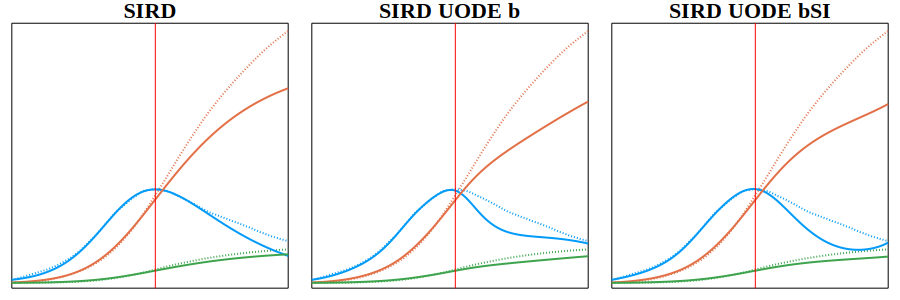

In [61]:
pl1 = plot(infOnda, lw = 2, color = 1, linestyle = :dot, label = "")
plot!(pl1, recOnda, lw = 2, color = 2, linestyle = :dot, label = "")
plot!(pl1, decOnda, lw = 2, color = 3, linestyle = :dot, label = "")

plot!(pl1, 1.:h:105., infSIR, lw = 2, color = 1, label = "Infectados")
plot!(pl1, 1.:h:105., recSIR, lw = 2, color = 2, label = "Recuperados")
plot!(pl1, 1.:h:105., decSIR, lw = 2, color = 3, label = "Decessos")

plot!(pl1, [N], seriestype = "vline", label = "", color = "red")

plot!(pl1, title = "SIRD", framestyle = :box, xlim = (1, 105), ylim = (-1_000, 48_500), legend = false)

pl2 = plot(infOnda, lw = 2, color = 1, linestyle = :dot, label = "Infectados (dados)")
plot!(pl2, recOnda, lw = 2, color = 2, linestyle = :dot, label = "Recuperados (dados)")
plot!(pl2, decOnda, lw = 2, color = 3, linestyle = :dot, label = "Decessos (dados)")

plot!(pl2, 1.:h:105., infUODE_1, lw = 2, color = 1)
plot!(pl2, 1.:h:105., recUODE_1, lw = 2, color = 2)
plot!(pl2, 1.:h:105., decUODE_1, lw = 2, color = 3)

plot!(pl2, [N], seriestype = "vline", label = "Último dia do ajuste", color = "red")

plot!(pl2, title = "SIRD UODE b", legend = false, framestyle = :box, xlim = (1, 105), ylim = (-1_000, 48_500))

pl3 = plot(infOnda, lw = 2, color = 1, linestyle = :dot, label = "Infectados (dados)")
plot!(pl3, recOnda, lw = 2, color = 2, linestyle = :dot, label = "Recuperados (dados)")
plot!(pl3, decOnda, lw = 2, color = 3, linestyle = :dot, label = "Decessos (dados)")

plot!(pl3, 1.:h:105., infUODE_2, lw = 2, color = 1)
plot!(pl3, 1.:h:105., recUODE_2, lw = 2, color = 2)
plot!(pl3, 1.:h:105., decUODE_2, lw = 2, color = 3)

plot!(pl3, [N], seriestype = "vline", label = "Último dia do ajuste", color = "red")

plot!(pl3, title = "SIRD UODE bSI", legend = false, framestyle = :box, xlim = (1, 105), ylim = (-1_000, 48_500))

fig1 = plot(pl1, pl2, pl3, layout = (1, 3), ticks = false, fontfamily = "Times Bold")

using Plots.PlotMeasures

plot!(fig1, size = (900, 300))

In [62]:
tols = [0.01, 0.015, 0.02, 0.025, 0.03, 0.05, 0.075, 0.1, 0.15, 0.2, 0.3]
#tols = [0.01, 0.015, 0.02, 0.025, 0.03, 0.05, 0.075, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5]

function compare(data, model)
    data = data[N+1:end]
    model = model[N+1:end]
    
    err = abs.(data .- model) ./ data
    
    [minimum(range(1, length(data)) .* (err .> tol) + (err .<= tol) .* length(data)) - 1 for tol in tols]
end

compare (generic function with 1 method)

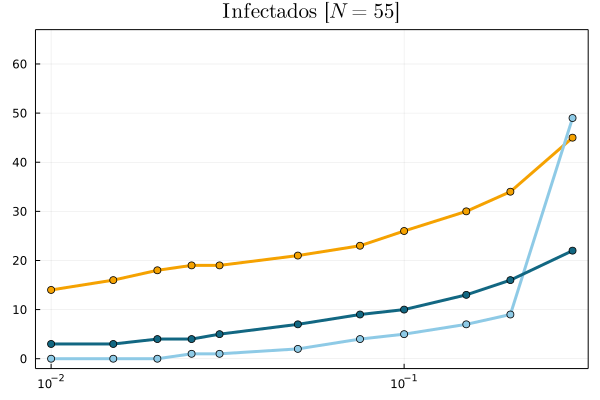

In [63]:
pl1 = plot(lw = 3, color = "#f5a201", tols, compare(infOnda, infSIR), label = "SIRD")
plot!(pl1, lw = 3, color = "#8ECAE6", tols, compare(infOnda, infUODE_1), label = "SIRD UODE β")
plot!(pl1, lw = 3, color = "#126782", tols, compare(infOnda, infUODE_2), label = "SIRD UODE βSI")

scatter!(pl1, markersize = 4, color = "#f5a201", tols, compare(infOnda, infSIR), label = "")
scatter!(pl1, markersize = 4, color = "#8ECAE6", tols, compare(infOnda, infUODE_1), label = "")
scatter!(pl1, markersize = 4, color = "#126782", tols, compare(infOnda, infUODE_2), label = "")

plot!(legend = :false, xscale = :log, framestyle = :box, title = L"\mathrm{Infectados} \hspace{0.5} [N = 55]",
    ylim = (-2, 67))

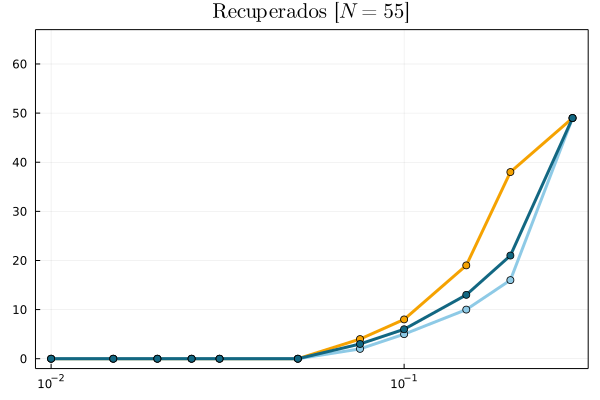

In [64]:
pl2 = plot(lw = 3, color = "#f5a201", tols, compare(recOnda, recSIR), label = "SIRD")
plot!(pl2, lw = 3, color = "#8ECAE6", tols, compare(recOnda, recUODE_1), label = "SIRD UODE β")
plot!(pl2, lw = 3, color = "#126782", tols, compare(recOnda, recUODE_2), label = "SIRD UODE βSI")

scatter!(pl2, markersize = 4, color = "#f5a201", tols, compare(recOnda, recSIR), label = "")
scatter!(pl2, markersize = 4, color = "#8ECAE6", tols, compare(recOnda, recUODE_1), label = "")
scatter!(pl2, markersize = 4, color = "#126782", tols, compare(recOnda, recUODE_2), label = "")

plot!(legend = false, xscale = :log, framestyle = :box, title = L"\mathrm{Recuperados} \hspace{0.5} [N = 55]",
    ylim = (-2, 67))

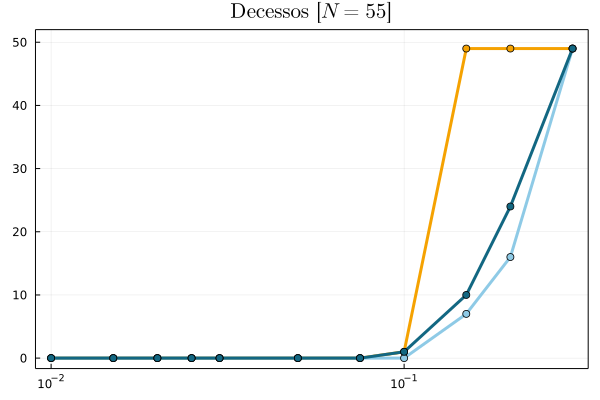

In [65]:
pl3 = plot(lw = 3, color = "#f5a201", tols, compare(decOnda, decSIR), label = "SIRD")
plot!(pl3, lw = 3, color = "#8ECAE6", tols, compare(decOnda, decUODE_1), label = "SIRD UODE β")
plot!(pl3, lw = 3, color = "#126782", tols, compare(decOnda, decUODE_2), label = "SIRD UODE βSI")

scatter!(pl3, markersize = 4, color = "#f5a201", tols, compare(decOnda, decSIR), label = "")
scatter!(pl3, markersize = 4, color = "#8ECAE6", tols, compare(decOnda, decUODE_1), label = "")
scatter!(pl3, markersize = 4, color = "#126782", tols, compare(decOnda, decUODE_2), label = "")

plot!(legend = false, xscale = :log, framestyle = :box, title = L"\mathrm{Decessos} \hspace{0.5} [N = 55]", 
    ylim = (-1.65, 52))

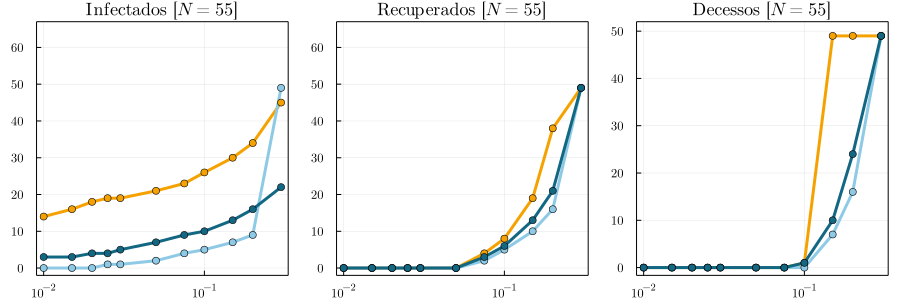

In [66]:
fig = plot(pl1, pl2, pl3, layout = (1, 3), fontfamily = "Computer Modern", titlefontsize = 12)

using Plots.PlotMeasures

plot!(fig, size = (900, 300))

display(fig)
savefig(fig, string("analysis_", N, "_days.pdf"))

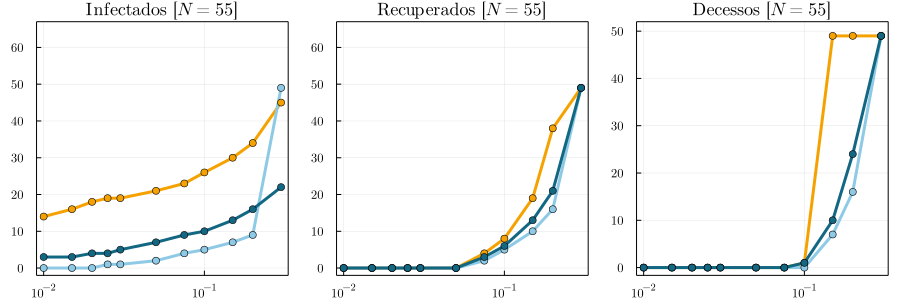

In [67]:
fig = plot(pl1, pl2, pl3, layout = (1, 3), fontfamily = "Computer Modern", titlefontsize = 12)

using Plots.PlotMeasures

plot!(fig, size = (900, 300))

display(fig)
savefig(fig, string("analysis_", N, "_days.pdf"))